### Modelos avanzados - Glove + LSTM

In [1]:
import random
random.seed(1)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns
import pandas as pd
import numpy as np

import re
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPool1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
def clean_text(text):
    html_text = BeautifulSoup(text,"html.parser").get_text()
    text = re.sub("[^a-zA-Z]", " ", html_text).strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub('http', ' ', text)
    text = re.sub('com', ' ', text)
    text = re.sub('  +', ' ', text)
    text = re.sub('\n', ' ', text)
    text = text.lower()
    
    return text


def stemSentence(text):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')

    stem_sentence = []
    for word in text.split():
        if word not in stop_words:
            if len(word)>2:
                stem_sentence.append(stemmer.stem(word))
          
    return " ".join(stem_sentence)


def lemmatize_sentence(text):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for word, tag in pos_tag(text.split()):
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        if word not in stop_words:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))

    return " ".join(lemmatized_sentence)

In [3]:
dt = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = 'latin-1', header = None)
dtt = pd.read_csv('data/testdata.manual.2009.06.14.csv', encoding = 'latin-1', header = None)
dt.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
dtt.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
dt = dt.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)
dtt = dtt.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

dtt = pd.concat([dtt[dtt['Sentiment'] == 0], dtt[dtt['Sentiment'] == 4]])
dt.head(5)

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
f={0 : 'Negative', 4 : 'Positive'}

def sentiment_decoder(sentiment):
    return f[sentiment]

dt.Sentiment = dt.Sentiment.apply(lambda x: sentiment_decoder(x))
dtt.Sentiment = dtt.Sentiment.apply(lambda x: sentiment_decoder(x))

print(len(dt), len(dtt))

1600000 359


In [5]:
# May make dataset smaller
dt_pos = dt[dt.Sentiment == 'Positive']
dt_neg = dt[dt.Sentiment == 'Negative']
dt_pos = dt_pos.iloc[:int(len(dt_pos)/1)]
dt_neg = dt_neg.iloc[:int(len(dt_neg)/1)]
dt = pd.concat([dt_pos[:30000], dt_neg[:30000]])
len(dt)

60000

In [6]:
dt.Tweet = dt.Tweet.apply(lambda x: clean_text(x))
dtt.Tweet = dtt.Tweet.apply(lambda x: clean_text(x))
dt.head()

,Sentiment,Tweet
800000,Positive,i love health uandpets u guys r the best
800001,Positive,im meeting up with one of my besties tonight c...
800002,Positive,darealsunisakim thanks for the twitter add sun...
800003,Positive,being sick can be really cheap when it hurts t...
800004,Positive,lovesbrooklyn he has that effect on everyone


In [7]:
#May use Stemma or Lemma
dt.Tweet = dt.Tweet.apply(lambda x: stemSentence(x))
dtt.Tweet = dtt.Tweet.apply(lambda x: stemSentence(x))

### Train and Test Split

In [8]:
train_data = dt
test_data = dtt

In [9]:
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 60000
Test Data size 359


### Tokenization

In [10]:
max_words = 100000
max_length = 100 #150

In [11]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data.Tweet)

word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_data.Tweet)
test_sequences = tokenizer.texts_to_sequences(test_data.Tweet)

print('Found %s unique tokens.' % len(word_index))

x_train = pad_sequences(train_sequences,
                        maxlen = max_length)
x_test = pad_sequences(test_sequences,
                       maxlen = max_length)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)


Found 49041 unique tokens.
Training X Shape: (60000, 100)
Testing X Shape: (359, 100)


In [12]:
labels = train_data.Sentiment.unique().tolist()

In [13]:
encoder = LabelEncoder()
encoder.fit(train_data.Sentiment.to_list())

y_train = encoder.transform(train_data.Sentiment.to_list())
y_test = encoder.transform(test_data.Sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000, 1)
y_test shape: (359, 1)


### Word Embeddings
### Global Vectors for Word Representation (GloVe)

In [14]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [15]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [16]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.100d.txt')

In [17]:
def cosine_similarity(u, v):
    distance = 0.0
    dot = np.dot(u, v)
    norm_u = np.linalg.norm(u, ord=2)
    norm_v = np.linalg.norm(v, ord=2)

    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity


In [18]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]

    words = word_to_vec_map.keys()
    max_cosine_sim = -100

    best_word = None

    for w in words:

        if w in [word_a, word_b, word_c]:
            continue

        cosine_sim = cosine_similarity(e_b-e_a, word_to_vec_map[w]-e_c)

        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w

    return best_word

In [19]:
cosine_similarity(word_to_vec_map['pasta'], word_to_vec_map['soup'])


0.7256871133170861

In [20]:
cosine_similarity(word_to_vec_map['hello'], word_to_vec_map['olive'])


0.016315451717840903

In [21]:
word_to_index['happy']

173081

In [22]:
word_to_vec_map['life']

array([ 0.25157  ,  0.4589   ,  0.30274  ,  0.12461  ,  0.15062  ,
        0.7373   , -0.31431  , -0.31305  , -0.40889  ,  0.042455 ,
       -0.42614  ,  0.49549  ,  0.010468 ,  0.22204  ,  0.028837 ,
       -0.59052  ,  0.53351  ,  0.17798  , -0.24486  ,  0.92695  ,
        0.27058  , -0.096303 , -0.0037595,  0.065192 ,  0.58494  ,
        0.39373  , -0.43439  , -1.0214   , -0.12035  ,  0.30562  ,
       -0.1696   ,  0.18668  , -0.44006  , -0.34578  , -0.46857  ,
        0.18542  , -0.30383  ,  0.49897  , -0.37543  , -0.52041  ,
       -0.5141   , -0.13442  ,  0.11745  , -0.13786  , -0.2505   ,
        0.41267  ,  0.06101  , -0.10372  ,  0.34358  , -0.53381  ,
       -0.013572 , -0.50581  ,  0.47017  ,  1.5464   ,  0.21803  ,
       -2.2455   ,  0.35391  , -0.12865  ,  1.587    ,  0.79569  ,
        0.15427  ,  1.262    , -0.26174  , -0.6863   ,  1.1039   ,
        0.33912  ,  0.88084  , -0.24413  ,  0.21744  , -0.21199  ,
        0.09736  , -0.17727  ,  0.062944 , -0.11046  ,  0.2185

In [23]:
examples = [('father', 'mother', 'son'), ]
for t in examples:
    print ('{} -> {} :: {} -> {}'.format( *t, complete_analogy(*t,word_to_vec_map)))

father -> mother :: son -> daughter


In [24]:
examples = [('italy', 'italian', 'spain'), ('norway', 'oslo', 'japan'), ('small', 'smaller', 'large')]
for t in examples:
    print ('{} -> {} :: {} -> {}'.format( *t, complete_analogy(*t,word_to_vec_map)))

italy -> italian :: spain -> spanish
norway -> oslo :: japan -> tokyo
small -> smaller :: large -> larger


In [25]:
LR = 1e-2 
BATCH_SIZE = 1024
EPOCHS = 8

In [26]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_length):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] 
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_length,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [27]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

learning_rate_reduction = [ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)]

model = Sequential()
model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_length))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , return_sequences = True, dropout = 0.1)))
model.add(Bidirectional(LSTM(units=100 , return_sequences = True, dropout = 0.1)))
model.add(Conv1D(100, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          40000100  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          285600    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [29]:
history = model.fit(x_train, y_train,
                    batch_size = BATCH_SIZE, 
                    validation_split=0.1,
                    epochs = EPOCHS, 
                    callbacks = learning_rate_reduction)

Epoch 1/8
53/53 [==============================] - 304s 6s/step - loss: 0.8335 - accuracy: 0.5573 - val_loss: 0.9213 - val_accuracy: 0.3875
Epoch 2/8
53/53 [==============================] - 307s 6s/step - loss: 0.6340 - accuracy: 0.6525 - val_loss: 0.7757 - val_accuracy: 0.5602
Epoch 3/8
53/53 [==============================] - 298s 6s/step - loss: 0.5972 - accuracy: 0.6933 - val_loss: 0.7483 - val_accuracy: 0.6600
Epoch 4/8
53/53 [==============================] - 299s 6s/step - loss: 0.5528 - accuracy: 0.7312 - val_loss: 0.7325 - val_accuracy: 0.6548
Epoch 5/8
53/53 [==============================] - 302s 6s/step - loss: 0.5136 - accuracy: 0.7544 - val_loss: 0.6254 - val_accuracy: 0.7085
Epoch 6/8
53/53 [==============================] - 301s 6s/step - loss: 0.4768 - accuracy: 0.7792 - val_loss: 0.7007 - val_accuracy: 0.6712
Epoch 7/8
53/53 [==============================] - 299s 6s/step - loss: 0.4499 - accuracy: 0.7941 - val_loss: 0.7896 - val_accuracy: 0.5793

Epoch 00007: Reduce

In [30]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 1s 647ms/step - loss: 0.5924 - accuracy: 0.7075

ACCURACY: 0.7075209021568298
LOSS: 0.5924474596977234


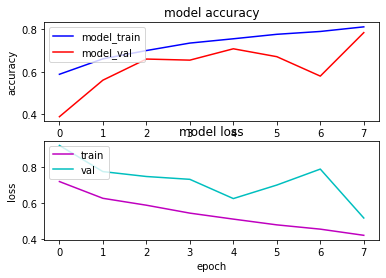

In [31]:
import matplotlib.pyplot as plt

s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['model_train', 'model_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')